Created by Zexuan Xu  
A naive try to fit price and item_seq_number with deal_probability using linear regression  
This obviously does not make sense, but provide an example for data processing and fitting with regression

In [1]:
import pandas as pd
import sqlite3
from sqlalchemy.engine import create_engine
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import datasets
from sklearn import preprocessing

If you alraedy load the csv in your database, simply comment the df.to_sql line

In [2]:
df = pd.read_csv('train.csv')
avito = sqlite3.connect("avito.db")
#df.to_sql('train', avito)

In [3]:
#df = pd.read_csv('test.csv')
#df.to_sql('test', avito)

In [4]:
train = pd.read_sql('SELECT * FROM train WHERE price > 10000', avito)
train

,index,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
0,4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.0,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797
1,6,c4f260a2b48a,08f469d2e6f7,Нижегородская область,Нижний Новгород,Для дома и дачи,Ремонт и строительство,Сантехника и сауна,None,None,Водонагреватель 100 литров нержавейка плоский,Электро водонагреватель накопительный на 100 л...,11000.0,125,2017-03-23,Private,0330f6ac561f5db1fa8226dd5e7e127b5671d44d075a98...,2823.0,0.00000
2,10,d5480bb4a6e4,d46200940f37,Ханты-Мансийский АО,Ханты-Мансийск,Недвижимость,Квартиры,Сдам,На длительный срок,1,"1-к квартира, 25 м², 2/2 эт.",Сдается однокомнатная мебелированная квартира ...,18000.0,6,2017-03-25,Private,645d3fb949cb116a00c596ca1e168d8c5ddd21cdeacc5a...,1396.0,0.58853
3,16,7896ef8fe482,007c6bd858cb,Краснодарский край,Краснодар,Транспорт,Автомобили,С пробегом,Chevrolet,Lanos,"Chevrolet Lanos, 2008","Кондиционер, гидроусилитель руля, электрически...",140000.0,201,2017-03-18,Company,5244375e00cb2baefa50f4b01156cc492f8733b93c6cba...,1118.0,0.32100
4,19,0658628930d4,27c2d83b766e,Белгородская область,Белгород,Недвижимость,"Дома, дачи, коттеджи",Сниму,Коттедж,На длительный срок,Сниму коттедж,Семейная пара из двух человек снимет коттедж с...,100000.0,5,2017-03-28,Private,None,NaN,0.10342
5,20,ea12aec32ec3,06ee4ff4e99c,Новосибирская область,Бердск,Недвижимость,Квартиры,Продам,2,Вторичка,"2-к квартира, 44 м², 5/5 эт.",Дом находиться внутри квартала./\nПластиковые ...,1748000.0,461,2017-03-17,Company,e9fb67b3d22cbf7cf569337780aea8a5c1ddac8b4b6b74...,2011.0,0.00000
6,22,de310e6aae86,0178e6308f38,Челябинская область,Магнитогорск,Транспорт,Автомобили,С пробегом,Ford,Focus,"Ford Focus, 2005",Полная комплектация. ГУР. 4 эсп. Подогрев сид...,249000.0,12,2017-03-20,Private,1c873f41cea87bc32f52d0a99cf5ff6a33305f0542b7f7...,2264.0,0.10334
7,33,c559542570bd,1446906a094c,Татарстан,Казань,Недвижимость,Комнаты,Продам,None,None,"Комната 8.2 м² в 5-к, 3/5 эт.",Продаю тёплую комнату с отличным новым ремонто...,900000.0,385,2017-03-21,Company,f1e11a40aaa06374bb8b1a551a85b6057754c06ecc0f0e...,2219.0,0.01635
8,34,2285e797fe2d,5977e301114d,Саратовская область,Саратов,Транспорт,Автомобили,С пробегом,Audi,80,"Audi 80, 1986","Отличный надёжный немец, на очень бодром ходу!...",65000.0,1,2017-03-25,Private,9dc0755c29addc765567c613087fbcabfd62f1555772f4...,1132.0,0.67548
9,38,f55eed4e831e,7e8eb4a5d1d5,Калининградская область,Гвардейск,Недвижимость,Коммерческая недвижимость,Продам,Складское помещение,None,Склад 70 м²,"Продается склад ГСМ, по адресу п. Истровка, Ка...",800000.0,6004,2017-03-28,Shop,None,NaN,0.06626


We only try to fit the items with price < 100000 in this naive case

In [6]:
train = pd.read_sql('SELECT price,item_seq_number,region,deal_probability FROM train WHERE price < 100000', avito).dropna()
train
list(train)[0:3]

['price', 'item_seq_number', 'region']

Use all data except the last 20 rows in train.csv for training  
Use the last 20 rows for testing 

In [7]:
X_train = train[['price','item_seq_number']].values[:-20]
y_train = train['deal_probability'].values[:-20]
#X_train.feature_names = ['price','item_seq_number']
y_train

array([0.12789, 0.     , 0.43177, ..., 0.3372 , 0.     , 0.     ])

In [8]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [9]:
print(regr.coef_)
print(regr.intercept_)

[ 1.88303144e-06 -2.20774904e-06]
0.12597589529413822


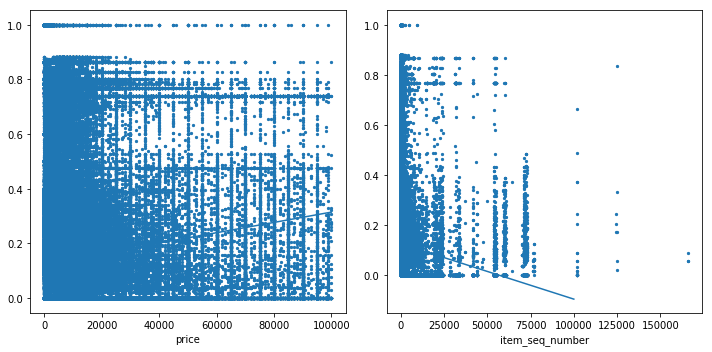

In [10]:
plt.figure(figsize=(10, 5))
linex = np.linspace(0.0, 100000.0, num=100)
for i, feat_name in enumerate(list(train)[0:2]):
    plt.subplot(1, 2, i+1)
    plt.scatter(X_train[:,i], y_train, s=5)
    plt.plot(linex, linex*regr.coef_[i]+regr.intercept_)
    plt.xlabel(feat_name)
plt.tight_layout()

Create a LASSO regression and compare with linear regression 

In [11]:
lasso = linear_model.Lasso()
lasso.fit(X_train, y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [13]:
X_test = train[['price','item_seq_number']].values[:-20]
y_test = train['deal_probability'].values[:-20]

In [14]:
print('Linear regression:', regr.score(X_test, y_test))
print('Lasso regression:', lasso.score(X_test, y_test))

Linear regression: 0.006265111412088964
Lasso regression: 0.006263771397466477


Dealing with categorical features

In [15]:
train['region'].nunique()

28

In [16]:
region = preprocessing.LabelEncoder()
region.fit(train['region'])  
list(region.classes_)
train['region'] = region.transform(train['region'])

In [17]:
X_train = train[['price','item_seq_number','region']].values[:-20]
y_train = train['deal_probability'].values[:-20]

In [18]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [19]:
print(regr.coef_)
print(regr.intercept_)
list(train)[0:3]

[ 1.88260576e-06 -2.21861412e-06 -1.75491217e-04]
0.12836113588166653


['price', 'item_seq_number', 'region']

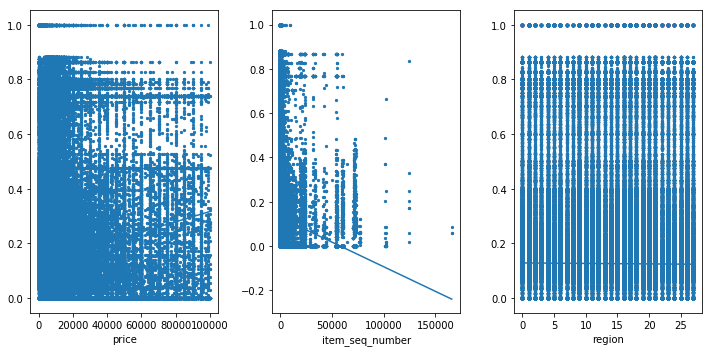

In [20]:
plt.figure(figsize=(10, 5))
for i, feat_name in enumerate(list(train)[0:3]):
    linex = np.linspace(0.0, max(X_train[:,i]), num=100)
    plt.subplot(1, 3, i+1)
    plt.scatter(X_train[:,i], y_train, s=5)
    plt.plot(linex, linex*regr.coef_[i]+regr.intercept_)
    plt.xlabel(feat_name)
plt.tight_layout()

As deal_probabilty might be related to category, I select the category with the largest number of items to try a naive linear regression

In [48]:
train = pd.read_sql('SELECT price,item_seq_number,region,category_name,deal_probability FROM train WHERE price < 100000', avito).dropna()
train['category_name'].nunique()

47

In [49]:
#train.groupby('category_name').count().sort_values(by='price', ascending=False).dropna()

In [50]:
region = preprocessing.LabelEncoder()
region.fit(train['region'])  
list(region.classes_)
train['region'] = region.transform(train['region'])

categ = preprocessing.LabelEncoder()
categ.fit(train['category_name'])  
list(categ.classes_)
train['category_name'] = categ.transform(train['category_name'])

In [51]:
train.groupby('category_name').count().sort_values(by='price', ascending=False).dropna()

,price,item_seq_number,region,deal_probability
category_name,,,,
29,278339,278339,278339,278339
10,265906,265906,265906,265906
42,98125,98125,98125,98125
41,64368,64368,64368,64368
22,62572,62572,62572,62572
38,50206,50206,50206,50206
34,41869,41869,41869,41869
4,32537,32537,32537,32537
44,28984,28984,28984,28984


In [59]:
train29 = train[train['category_name'] == 29]
X_train29 = train29[['price','item_seq_number','region']].values[:-20]
y_train29 = train29['deal_probability'].values[:-20]

In [60]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
regr.fit(X_train29, y_train29)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [61]:
print(regr.coef_)
print(regr.intercept_)
list(train)[0:3]

[-9.03127023e-07 -1.30027020e-06  7.29672440e-06]
0.048218553263090894


['price', 'item_seq_number', 'region']

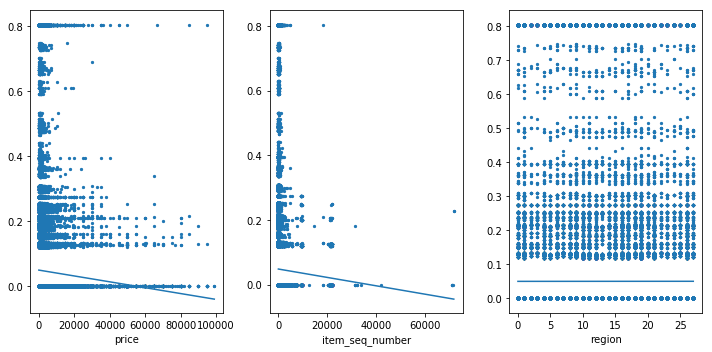

In [62]:
plt.figure(figsize=(10, 5))
for i, feat_name in enumerate(list(train29)[0:3]):
    linex = np.linspace(0.0, max(X_train29[:,i]), num=100)
    plt.subplot(1, 3, i+1)
    plt.scatter(X_train29[:,i], y_train29, s=5)
    plt.plot(linex, linex*regr.coef_[i]+regr.intercept_)
    plt.xlabel(feat_name)
plt.tight_layout()